<a href="https://colab.research.google.com/github/NolanRink/CS4540/blob/main/HW14/P3CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.cuda.is_available())   # should print True
!nvidia-smi                        # shows the GPU details


True
Mon Apr 28 23:25:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 1. Imports and Device Setup
Import all required Python libraries and configure cuDNN for optimized convolutions. Detect whether a CUDA GPU is available and set the `device` accordingly for all tensor operations.

In [14]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 2. Data Loading
Load the raw LFP recordings for each subject from the provided HDF5 files. Assign binary labels (`0=WAKE`, `1=NREM`) to each segment and store the data and sampling rates in a dictionary.


In [15]:
files = ["Rat08-20130711_017.h5", "Part1SubjectHB10.h5", "Part2SubjectHB13.h5"]
subject_names = ["Rat08_HPC", "SubjectHB10_BLA", "SubjectHB13_BLA"]

data_dict = {}
for subject, filename in zip(subject_names, files):
    segments, labels = [], []
    with h5py.File(filename, 'r') as f:
        fs = f.attrs.get('fs', 1250)
        for state in f.keys():
            lab = 1 if state == "NREM" else 0
            for seg in f[state].values():
                segments.append(seg[()].astype(float))
                labels.append(lab)
    data_dict[subject] = {"segments": segments, "labels": np.array(labels), "fs": fs}
    print(f"{subject}: Loaded {len(segments)} segments")


Rat08_HPC: Loaded 96 segments
SubjectHB10_BLA: Loaded 55 segments
SubjectHB13_BLA: Loaded 41 segments


## 3. Preprocessing: 5-Second Clip Segmentation
Break each continuous recording into fixed 5-second clips (based on sampling rate) and discard any partial segments. Assemble all clips and corresponding labels into NumPy arrays for each subject.

In [16]:
clip_duration = 5
processed_data = {}
for subject in subject_names:
    fs = data_dict[subject]["fs"]
    clip_length = int(clip_duration * fs)
    Xc, yc = [], []
    segs, labs = data_dict[subject]["segments"], data_dict[subject]["labels"]
    for seg, lab in zip(segs, labs):
        if len(seg) < clip_length:
            continue
        n = len(seg) // clip_length
        clips = seg[:n * clip_length].reshape(n, clip_length)
        Xc.extend(clips)
        yc.extend([lab]*n)
    Xc, yc = np.array(Xc), np.array(yc)
    print(f"{subject}: {len(Xc)} clips ({yc.sum()} NREM, {len(yc)-yc.sum()} WAKE)")
    processed_data[subject] = {"X": Xc, "y": yc, "fs": fs}


Rat08_HPC: 3682 clips (1239 NREM, 2443 WAKE)
SubjectHB10_BLA: 907 clips (330 NREM, 577 WAKE)
SubjectHB13_BLA: 913 clips (295 NREM, 618 WAKE)


<ipython-input-16-32e70e6ec7f1>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  clip_length = int(clip_duration * fs)


## 4. Train/Validation/Test Split & Normalization
Split each subject’s clips into train (70%), validation (15%), and test (15%) sets using stratified sampling to preserve class balance. Compute the training-set mean and standard deviation, then apply z-score normalization to all splits.


In [17]:
splits = {}
for subject in subject_names:
    X, y = processed_data[subject]["X"], processed_data[subject]["y"]
    X_tv, X_test, y_tv, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(
        X_tv, y_tv, test_size=0.15/0.85, random_state=42, stratify=y_tv)
    m, s = X_train.mean(), X_train.std()
    splits[subject] = {
        "X_train": (X_train - m)/s, "y_train": y_train,
        "X_val":   (X_val   - m)/s, "y_val":   y_val,
        "X_test":  (X_test  - m)/s, "y_test":  y_test
    }
    print(f"{subject}: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")


Rat08_HPC: Train=2576, Val=553, Test=553
SubjectHB10_BLA: Train=634, Val=136, Test=137
SubjectHB13_BLA: Train=639, Val=137, Test=137


## 5. DataLoaders with Mini-batching
Convert the normalized NumPy arrays into PyTorch `TensorDataset` objects and wrap them in `DataLoader's` with a chosen batch size, shuffling for training, and multi-worker pinning for faster GPU transfers.


In [18]:
batch_size = 64
loaders = {}
for subject in subject_names:
    sp = splits[subject]
    X_tr = torch.tensor(sp["X_train"], dtype=torch.float32).unsqueeze(1)
    y_tr = torch.tensor(sp["y_train"], dtype=torch.long)
    X_val = torch.tensor(sp["X_val"],   dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(sp["y_val"],   dtype=torch.long)
    X_te = torch.tensor(sp["X_test"],  dtype=torch.float32).unsqueeze(1)
    y_te = torch.tensor(sp["y_test"],  dtype=torch.long)

    train_ds = TensorDataset(X_tr, y_tr)
    val_ds   = TensorDataset(X_val, y_val)
    test_ds  = TensorDataset(X_te, y_te)

    loaders[subject] = {
        'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                            num_workers=2, pin_memory=True),
        'val':   DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True),
        'test':  DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)
    }


## 6. Define the CNN Model with Global Pooling
Implement a simple 1D CNN with two convolution + max-pool layers, followed by an adaptive global average pooling to collapse each feature map to one value. Final classification is done by a small fully connected layer.


In [19]:
class SleepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=7)
        self.pool  = nn.MaxPool1d(2)
        self.gpool = nn.AdaptiveAvgPool1d(1)
        self.fc    = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.gpool(x)          # [B,32,1]
        x = x.squeeze(-1)          # [B,32]
        return self.fc(x)


## 7. Training Function with AMP & Early Stopping
Create a reusable `train_model()` function that:
- Moves data and model to the chosen device  
- Uses mixed-precision (`torch.cuda.amp`) for faster training  
- Tracks train/validation accuracy each epoch  
- Saves the best model based on validation accuracy  
- Implements early stopping if no improvement after a set patience

In [20]:
def train_model(subj, model, train_loader, val_loader,
                epochs=100, lr=0.01, patience=10):
    model.to(device)
    crit = nn.CrossEntropyLoss().to(device)
    opt  = optim.Adam(model.parameters(), lr=lr)
    scaler = GradScaler()

    best_val, wait = 0.0, 0
    history = {'train_acc':[], 'val_acc':[]}

    for ep in range(1, epochs+1):
        model.train()
        correct_tr, total_tr = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            opt.zero_grad()
            with autocast():
                out = model(xb)
                loss = crit(out, yb)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            pred = out.argmax(1)
            correct_tr += (pred==yb).sum().item()
            total_tr   += yb.size(0)
        tr_acc = correct_tr/total_tr

        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                pred = out.argmax(1)
                correct_val += (pred==yb).sum().item()
                total_val   += yb.size(0)
        val_acc = correct_val/total_val

        history['train_acc'].append(tr_acc)
        history['val_acc'].append(val_acc)
        print(f"{subj} Epoch {ep}/{epochs} | Train {tr_acc*100:.1f}% | Val {val_acc*100:.1f}%")

        if val_acc > best_val:
            best_val, wait = val_acc, 0
            torch.save(model.state_dict(), f"{subj}_best.pt")
        else:
            wait += 1
            if wait>=patience:
                print("Early stopping.")
                break

    model.load_state_dict(torch.load(f"{subj}_best.pt"))
    return history, model


## 8. Train Models for All Subjects
Loop through each subject, instantiate a fresh CNN, and call `train_model()` to train on that subject’s data. Store both the trained model and its training history.


In [21]:
models, histories = {}, {}
for subj in subject_names:
    print(f"\n--- Training CNN for {subj} ---")
    hist, mdl = train_model(
        subj,
        SleepCNN(),
        loaders[subj]['train'],
        loaders[subj]['val'],
        epochs=100,
        lr=0.01,
        patience=10
    )
    histories[subj], models[subj] = hist, mdl



--- Training CNN for Rat08_HPC ---


<ipython-input-20-602531b6333a>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-20-602531b6333a>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Rat08_HPC Epoch 1/100 | Train 65.3% | Val 65.5%
Rat08_HPC Epoch 2/100 | Train 65.9% | Val 64.2%
Rat08_HPC Epoch 3/100 | Train 66.1% | Val 67.6%
Rat08_HPC Epoch 4/100 | Train 65.7% | Val 64.9%
Rat08_HPC Epoch 5/100 | Train 69.0% | Val 79.0%
Rat08_HPC Epoch 6/100 | Train 70.4% | Val 66.0%
Rat08_HPC Epoch 7/100 | Train 71.1% | Val 66.7%
Rat08_HPC Epoch 8/100 | Train 71.7% | Val 68.9%
Rat08_HPC Epoch 9/100 | Train 71.9% | Val 69.1%
Rat08_HPC Epoch 10/100 | Train 73.9% | Val 80.1%
Rat08_HPC Epoch 11/100 | Train 75.5% | Val 76.9%
Rat08_HPC Epoch 12/100 | Train 75.9% | Val 81.2%
Rat08_HPC Epoch 13/100 | Train 77.2% | Val 77.0%
Rat08_HPC Epoch 14/100 | Train 77.6% | Val 76.3%
Rat08_HPC Epoch 15/100 | Train 78.8% | Val 82.6%
Rat08_HPC Epoch 16/100 | Train 80.4% | Val 82.6%
Rat08_HPC Epoch 17/100 | Train 82.6% | Val 77.0%
Rat08_HPC Epoch 18/100 | Train 82.7% | Val 83.4%
Rat08_HPC Epoch 19/100 | Train 83.1% | Val 85.0%
Rat08_HPC Epoch 20/100 | Train 86.4% | Val 75.9%
Rat08_HPC Epoch 21/100 | Trai

## 9. Plot Training History for First Subject
Visualize the training and validation accuracy curves over epochs for one example subject to diagnose learning dynamics and check for overfitting or underfitting.

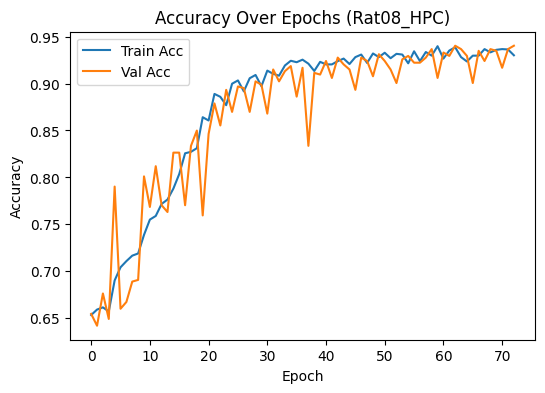

In [22]:
sub0 = subject_names[0]
plt.figure(figsize=(6,4))
plt.plot(histories[sub0]['train_acc'], label="Train Acc")
plt.plot(histories[sub0]['val_acc'],   label="Val Acc")
plt.title(f"Accuracy Over Epochs ({sub0})")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.show()


## 10. Evaluate on Test Sets
Load each subject’s best-saved model, run inference on the held-out test set, compute overall test accuracy, and display the confusion matrix to inspect classification errors.

In [23]:
for subj in subject_names:
    mdl = models[subj].eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for xb, yb in loaders[subj]['test']:
            xb = xb.to(device)
            p = mdl(xb).argmax(1).cpu().numpy()
            preds_all.extend(p)
            labels_all.extend(yb.numpy())
    preds_all = np.array(preds_all)
    labels_all = np.array(labels_all)
    acc = (preds_all==labels_all).mean()
    cm  = confusion_matrix(labels_all, preds_all)
    print(f"\n{subj} Test Acc: {acc*100:.2f}%\nConfusion Matrix:\n{cm}")



Rat08_HPC Test Acc: 93.85%
Confusion Matrix:
[[347  20]
 [ 14 172]]

SubjectHB10_BLA Test Acc: 96.35%
Confusion Matrix:
[[87  0]
 [ 5 45]]

SubjectHB13_BLA Test Acc: 100.00%
Confusion Matrix:
[[93  0]
 [ 0 44]]
